In [6]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import os, os.path
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode

import io
import cv2 # OpenCV library
from google.colab.patches import cv2_imshow

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Ecriture des images sous forme de fichier

Je vais utiliser 16x16 photos parce que la quantité de données est trop grande pour fonctionner trop lentement dans d’autres formats

En outre, je vais stocker les valeurs des pixels dans la boîte de geste de détection sous une forme numérique dans un fichier txt pour la formation ultérieure

Voici mon chemin de fichier photo : 

In [7]:
chemin_16 = '/content/drive/MyDrive/mam4_CV/Mydataset/16'

On va passer à l'écriture des images dans un fichier.

In [8]:
def images_to_file(chemin, fichier):
  """Prend en argument
  chemin : le chemin du dossier dans lequel ce trouve nos images
  fichier : le chemin du fichier dans lequel on souhaite ecrire les images
  
  Ecris les images sous forme de tableau dans le fichier"""
  
  # nombre d'images dans le dossier
  nb_photo = len([name for name in os.listdir(chemin) if os.path.isfile(os.path.join(chemin, name))])
  nb_photo = int(nb_photo/2)

  #ouverture du fichier dans lequel on écrit
  f = open(fichier, "a")
  
  # on parcourt toutes les images 
  for i in range(10,nb_photo):
  
    # on ouvre l'image
    nom_img = chemin + '/' + str(i) + '.jpg'
    image = Image.open(nom_img)
    
    # on ouvre l'image tournée
    nom_img2 = chemin + '/' + str(i) + 'flipped.jpg'
    image_flipped = Image.open(nom_img2)
    
    # on transforme les image en tableau
    img_array = np.array(image).reshape((16*16,))
    img_array_flipped = np.array(image_flipped).reshape((16*16,))
    
    # on écrit dans le fichier

    t1 = str(img_array)
    t1 = t1[1:-1]
    t1 = t1.replace("\n",'')

    t2 = str(img_array_flipped)
    t2 = t2[1:-1]
    t2 = t2.replace("\n",'')

    ligne = chemin[-1] + " " + t1 + "\n"
    f.write(ligne)
    ligne2 = chemin[-1] + " " + t2 + "\n"
    f.write(ligne2)


  # on ferme le fichier
  f.close()


## Création de notre fichier pour toutes les lettres.

In [9]:
lettres = ["A",'B','C'] # tableau contenant les lettres dont on a des images

Pour chaque lettre, on va écrire toutes les images correspondantes dans un fichier qu'on appelle essai2.txt

In [10]:
for l in lettres:
  images_to_file(chemin_16+'/'+l, '/content/data.txt')

## Mélange aléatoire des lignes

On mélange les lignes pour éviter d'avoir que des S dans le training set par exemple.

In [11]:
lines = open('/content/data.txt').readlines()
random.shuffle(lines)
open('/content/data.txt', 'w').writelines(lines)

## Chargement de notre dataset

In [12]:
def load_dataset(dataset_file_path):
  """fonction qui lit le fichier d'images et sépare les images de leur classe"""
  a = np.loadtxt(dataset_file_path, converters={0:lambda ch : ord(ch)-ord('A')}) #permet de lire ligne par ligne et de convertir la lettre en numéro
  samples, letters = a[:,1:], a[:,0] # sépare l'image du numéro de la lettre
  return samples, letters

In [13]:
dataset_file_path = '/content/data.txt'
samples, letters = load_dataset(dataset_file_path)


In [14]:
lettre_dico = {0 : 'A', 1 : 'B', 2 : 'C'}


In [15]:
ref = np.unique(letters)
n = len(ref)

new_val = range(5)
for i in range(n):
  letters = np.where(letters==ref[i], i, letters) 

## séparer en training set, validation test et testing test
On sépare en 3 parties : 
1. training set -> 0.6%
2. validation set -> 0.3%
3. test set -> 0.1%

In [16]:
train_ratio = 0.6
val_ratio = 0.3
n_train_samples = int(len(samples) * train_ratio)

n_val_samples = n_train_samples + int(len(samples) * val_ratio)

x_train, y_train = samples[:n_train_samples], letters[:n_train_samples]
x_val, y_val = samples[n_train_samples:n_val_samples], letters[n_train_samples:n_val_samples]
x_test, y_test = samples[n_val_samples:], letters[n_val_samples:]

print(len(x_train) ,"images pour le training set")
print(len(x_val),"images pour le validation set")
print(len(x_test),"images pour le test set")

320 images pour le training set
160 images pour le validation set
54 images pour le test set


In [17]:
num_classes = 5 # 5 lettres à prédire


x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255
x_val /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)



In [18]:

# Création du model ML
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(256,)))
model.add(Dropout(0.2)) # on met 2% des poids des neurones à 0
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax')) #En prend num_classes car on a num_classes à prédire

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               25700     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5

In [21]:

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [19]:
accuracy_val = [] #vecteur qui stocke la validation accuracy au court des modifications du modèle.

In [22]:
#notre entrainement s'arrete si val_loss ne diminue plus en 2 étapes
my_callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2) ]
epochs = 30
history = model.fit(x_train, y_train,
                    epochs=epochs,
                    verbose=1,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    callbacks = my_callbacks)



Epoch 1/30
4/4 [==============================] - 3s 95ms/step - loss: 1.4762 - accuracy: 0.3347 - val_loss: 1.0263 - val_accuracy: 0.6812
Epoch 2/30
4/4 [==============================] - 0s 16ms/step - loss: 0.9595 - accuracy: 0.6470 - val_loss: 0.6400 - val_accuracy: 0.9250
Epoch 3/30
4/4 [==============================] - 0s 15ms/step - loss: 0.7149 - accuracy: 0.7441 - val_loss: 0.3873 - val_accuracy: 0.9688
Epoch 4/30
4/4 [==============================] - 0s 17ms/step - loss: 0.5363 - accuracy: 0.8490 - val_loss: 0.3396 - val_accuracy: 0.8938
Epoch 5/30
4/4 [==============================] - 0s 15ms/step - loss: 0.4076 - accuracy: 0.8650 - val_loss: 0.2022 - val_accuracy: 0.9500
Epoch 6/30
4/4 [==============================] - 0s 15ms/step - loss: 0.2534 - accuracy: 0.9494 - val_loss: 0.1722 - val_accuracy: 0.9812
Epoch 7/30
4/4 [==============================] - 0s 15ms/step - loss: 0.1895 - accuracy: 0.9664 - val_loss: 0.1140 - val_accuracy: 0.9937
Epoch 8/30
4/4 [===========

In [23]:
score = model.evaluate(x_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
accuracy_val.append(score[1])

Validation loss: 0.044816114008426666
Validation accuracy: 0.981249988079071


In [24]:
print(accuracy_val)

[0.981249988079071]


Je vais maintenant tester mon modèle sur mon testing set. Pour cela je prépare d'abord les données.

In [25]:
x_test = x_test.astype('float32')
x_test /= 255
y_test = keras.utils.to_categorical(y_test, num_classes)
print(x_test.shape)

(54, 256)


La commande np.argmax permet de récupérer l'indice du maximum, qui est la classe prédite.

In [26]:
y_predict = np.argmax(model.predict(x_test),axis = 1)

In [27]:
y_test_cat = np.argmax(y_test,axis = 1)
erreur = y_predict - y_test_cat

In [28]:
print(np.linalg.norm(erreur))

0.0


In [29]:
print(np.shape(np.where(erreur != 0)))

(1, 0)


In [30]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_weights.h5")
print("Saved model to disk")

Saved model to disk


J'importe le modèle qui correspond au meilleur modèle que j'ai obtenu lors de la phase d'entrainement.

In [27]:
from keras.models import model_from_json

# load json and create model
json_file = open('/content/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/content/model_weights.h5")

In [28]:
from google.colab.output import eval_js

def VideoCapture():
  """fonction qui permet d'utilier notre camera"""
  js = Javascript('''
    async function create(){
      div = document.createElement('div');
      document.body.appendChild(div);

      video = document.createElement('video');
      video.setAttribute('playsinline', '');

      div.appendChild(video);
      stream = await navigator.mediaDevices.getUserMedia({video: {facingMode: "environment"}});
      video.srcObject = stream;

      await video.play();

      canvas =  document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      div_out = document.createElement('div');
      document.body.appendChild(div_out);
      img = document.createElement('img');
      div_out.appendChild(img);
    }

    async function capture(){
        return await new Promise(function(resolve, reject){
            pendingResolve = resolve;
            canvas.getContext('2d').drawImage(video, 0, 0);
            result = canvas.toDataURL('image/jpeg', 0.20);

            pendingResolve(result);
        })
    }

    function showimg(imgb64){
        img.src = "data:image/jpg;base64," + imgb64;
    }

  ''')
  display(js)

In [29]:
def b64_to_bytes(byte):
  jpeg = b64decode(byte.split(',')[1])
  im = Image.open(io.BytesIO(jpeg))
  return np.array(im)

def bytes_to_b64(image):
  image = Image.fromarray(image)
  buffer = io.BytesIO()
  image.save(buffer, 'jpeg')
  buffer.seek(0)
  x = b64encode(buffer.read()).decode('utf-8')
  return x

In [31]:
# Load cascades using cv2.CascadeClassifier
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/mam4_CV/haarcascade_frontalface_alt.xml')

In [32]:
def show_hist(hist):
  bin_count = hist.shape[0]
  bin_w = 24
  img = np.zeros((256, bin_count*bin_w, 3), np.uint8)
  for i in range(bin_count):
      h = int(hist[i])
      cv2.rectangle(img, (i*bin_w+2, 255), ((i+1)*bin_w-2, 255-h), (int(180.0*i/bin_count), 255, 255), -1)
  img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
  cv2_imshow(img)

In [33]:
def detect_faces(img, cascades):
  """trouve les visages dans une image"""
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = cascades.detectMultiScale(gray, 1.3, 4)
  return faces

In [48]:
VideoCapture()
eval_js('create()')

while True:
  response = input("Type anything when ready!:")
  byte = eval_js('capture()')
  im = b64_to_bytes(byte)
  im_copy = im.copy()
  faces = detect_faces(im, face_cascade)

  if len(faces) == 1:
    face = faces[0]
    cv2.rectangle(im_copy,(face[0],face[1]),(face[0] + face[2], face[1] + face[3]),(0,255,0),2)
  else:
    continue

  eval_js('showimg("{}")'.format(bytes_to_b64(im_copy)))
  response = input("Use this bounding box? [y or n]:")
  if response == 'y':
    frame = im[face[1]:face[1]+face[3], face[0]:face[0]+face[2]]
    eval_js('showimg("{}")'.format(bytes_to_b64(frame)))
    #zone de notre visage
    tracking_window_face = face
    break

<IPython.core.display.Javascript object>

Type anything when ready!:y
Use this bounding box? [y or n]:y


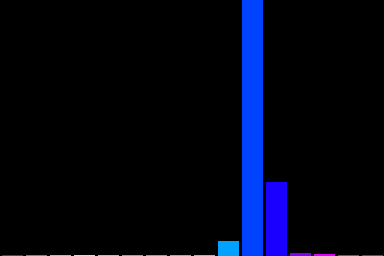

In [35]:
# on passe du domaine RGB au domaine HSV
frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

#Creation d'un mask: on limite la saturation entre 64 et 255, la brillance entre 32 et 200
mask = cv2.inRange(frame_hsv, np.array((0.,64.,32.)), np.array((180.,255.,200.)))


# Calcul d'un histogramme de la zone de visage uniquement sur le canal de teinte (="hue")
# on utilise le mask calculé précédemment
# on veut 16 catégories qui vont de 0 à 180
frame_hist = cv2.calcHist([frame_hsv], [0], mask, [16], [0,180])

# On normalise l'histogramme entre 0 et 255 grâce à `cv.NORM_MINMAX`
frame_hist = cv2.normalize(frame_hist, frame_hist, 0,255,cv2.NORM_MINMAX)


# On transforme l'histogramme en 1-D array
frame_hist = frame_hist.reshape(-1)

# On affiche l'histogramme
from google.colab.patches import cv2_imshow
show_hist(frame_hist)

In [36]:
def scale_contour(pts, scale_x, scale_y):
  "fonction qui permet de redimensionner le rectangle"
  M = cv2.moments(pts)

  if M['m00'] == 0:
    return pts
  cx = int(M['m10']/M['m00'])
  cy = int(M['m01']/M['m00'])

  cnt_norm = pts - [cx, cy]
  cnt_scaled = cnt_norm * np.array([scale_x, scale_y])
  cnt_scaled = cnt_scaled + [cx, cy]
  cnt_scaled = cnt_scaled.astype(np.int32)

  return cnt_scaled

def crop_hand(pts, im_w, im_h):
  """Le but de cette fonction est de construire un rectangle qui n'est pas tourné et qui ne dépasse pas de l'image """
  # pour l'abscisse du point en haut à gauche on prend le max entre 0 et la plus petite abscisse dans pts, idem avec l'ordonnee
  x_hg , y_hg = max(0,min(pts[:,0])), max(0,min(pts[:,1]))
  # pour l'abscisse du point en bas à droite, on prend le min entre la largeur de l'image et la plus grande abscisse dans pts
  x_bd, y_bd = min(im_w,max(pts[:,0])), min(im_h,max(pts[:,1]))
  return (x_hg,y_hg),(x_bd,y_bd)




In [47]:
from PIL import ImageDraw
# font
font = cv2.FONT_HERSHEY_SIMPLEX
  
# org
org = (50, 50)
  
# fontScale
fontScale = 1

VideoCapture()
eval_js('create()')

# Critère d'arrêt : 
#  si on a fait 10 itération
# ou
#  si la moyenne calculée ne bouge plus assez 
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )


byte = eval_js('capture()') # prend une capture
im = b64_to_bytes(byte) # transformation
im_w = im.shape[1] # largeur de l'image
im_h = im.shape[0] # hauteur de l'image
tracking_window_hand = (0,0,im_w, im_h)
cpt = -1
while cpt < 10:
  byte = eval_js('capture()') # Take a capture
  img = b64_to_bytes(byte)

  # On passe du domaine RGB au domaine HSV
  hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

  #Creation d'un mask: on limite la saturation entre 64 et 255, la brillance entre 32 et 200
  mask = cv2.inRange(hsv, np.array((0.,64.,32.)), np.array((180.,255.,200.)))


  # On projette l'histogramme de la zone de visage sur l'image. 
  # On utilise uniquement le canal 0 (=Hue), entre 0 et 180 avec une échelle de 1
  prob = cv2.calcBackProject([hsv] , [0], frame_hist, [0,180], scale = 1)
  
  # bit a bit entre la projection et le mask pour enlever les pixel trop brillant ou trop foncé
  prob = prob & mask
  

  # on calcule le camshift
  bbox, tracking_window_face = cv2.CamShift(prob, tracking_window_face , term_crit)

  # permet d'augmenter la taille du rectangle pour être certain de couvrir tout notre visage
  pts = cv2.boxPoints(bbox).astype(np.int)
  sc = scale_contour(pts, 1.5, 1.5)
  # met notre visage en noir 
  cv2.fillPoly(prob, [sc], 0) 

  # on regarde ou se trouve notre visage
  (x,y,w,h) = tracking_window_face

  #on va mettre en noir le dessus et dessous de notre tête
  margin = 10
  lignes_bas = max(0, y-margin)
  lignes_haut = min(im_h, y+h+margin)
  col_bas = max(0, x-margin)
  col_haut = min(im_w, x+w+margin)
  

  #on met en noir toute la zone au dessus de notre tete
  prob[0:lignes_bas, 0:im_w] = 0

  #on met en noir toute la zone en dessous de notre tete
  prob[lignes_haut:im_h, 0:im_w] = 0
  

  #detection de la main
  bbox2, tracking_window_hand = cv2.CamShift(prob, tracking_window_hand, term_crit)
  
  # on ajuste la taille de la boite autour de notre main
  pts2 = cv2.boxPoints(bbox2).astype(np.int)
  pts2 = scale_contour(pts2,2,2)

  #met le rectangle de notre main en gris 
  #cv2.polylines(prob,[pts2],True,(100,0,0),2)
  

  # on prend un rectangle "droit"
  cropped_hand_bbox = crop_hand(pts2, im_w,im_h)

  x1 = cropped_hand_bbox[0][0]
  y1 = cropped_hand_bbox[0][1]
  x2 = cropped_hand_bbox[1][0]
  y2 = cropped_hand_bbox[1][1]
  # on affiche un rectancle blanc autour de note main
  cv2.rectangle(prob,(x1,y1),  (x2,y2), (255,0,0))
  
  cropped_hand = cv2.cvtColor(im[y1:y2, x1:x2],cv2.COLOR_RGB2GRAY)
  
  # on augmente le nombre d'image enregistrees
  cpt +=1
  
  #*********************************************** taille 16 *****************************
  # on ajuste la taille
  cropped_hand16 = cv2.resize(cropped_hand,(16,16))

  # on met notre image en tableau
  img_array = np.array(cropped_hand16).reshape((1,16*16))

  x_test2 = img_array.astype('float32')
  x_test2 /= 255
  y_predict = np.argmax(model.predict(x_test2),axis = 1)
  lettre = lettre_dico[y_predict[0]]
 
  


  #on ouvre l'image avec PIL
  #img_PIL = Image.open(chemin_tot)

  cv2.putText(prob, lettre,org = (100,50), fontFace=font, fontScale = fontScale, color = 255)

  #*********** on affiche l'image en noir et blanc pour être certain e bien detecter la main ******
  eval_js('showimg("{}")'.format(bytes_to_b64(prob)))

<IPython.core.display.Javascript object>

Voici c'est les exemples

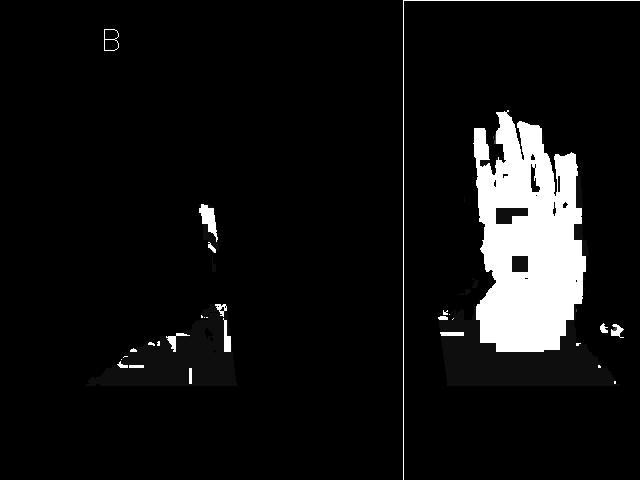

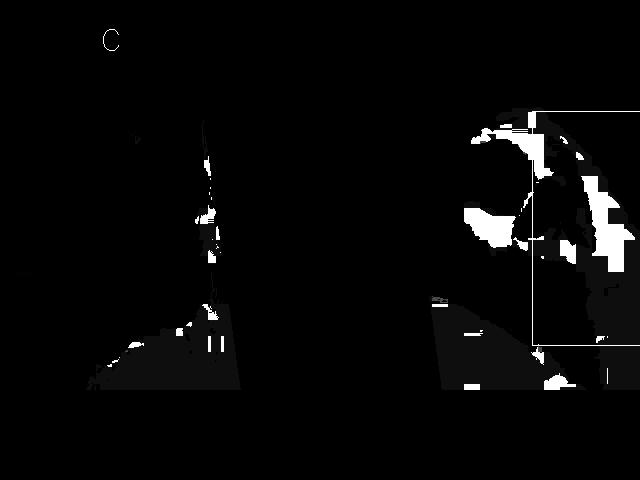